# Building: The Informed Airline Customer Support Agent


Project Overview: Informed Airline Customer Support Agent

**Introduction:**

The objective of this project is to develop an advanced AI-powered chatbot tailored for airline and travel booking services, featuring multimodal capabilities. It integrates large language models such as LLaMA for text generation, Flux for image generation, and text-to-speech (TTS) systems for converting responses into audio output.

In [1]:
# Import the modules

# For environment and system
import os
from dotenv import load_dotenv
import json

# For API
from openai import OpenAI
from groq import Groq
import requests

# Python modules for handling audio 
from pydub import AudioSegment
import subprocess
import uuid
from IPython.display import Audio, display

# Python modules for handling image
import base64
from io import BytesIO
from PIL import Image

# For UI
import gradio as gr

### API Integration

For this project, I plan to integrate open-source AI models available throgh Groq's API services.

In [3]:
load_dotenv()

api_key_1 = os.getenv("GROQ_API_KEY")

groq_models = Groq(api_key=api_key_1)

MODEL_TEXT = "meta-llama/llama-4-scout-17b-16e-instruct"

In [4]:
api_key_2 = os.getenv("api_key_yt")
base_url = "https://api.a4f.co/v1"

openai = OpenAI(api_key = api_key_2, base_url=base_url)

MODEL_IMG = "provider-1/FLUX.1-dev"
MODEL_AUD = "provider-3/tts-1"

# Model 1: Image generation

In [5]:
def image_model(city):
    image_response = openai.images.generate(
        model = MODEL_IMG,
        prompt = f"An image representing an vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant and pop u style",
        size = "1024x1024",
        n=1,
        response_format = "b64_json"
    )
    imagebs4 = image_response.data[0].b64_json
    image_data = base64.b64decode(imagebs4)
    return Image.open(BytesIO(image_data))

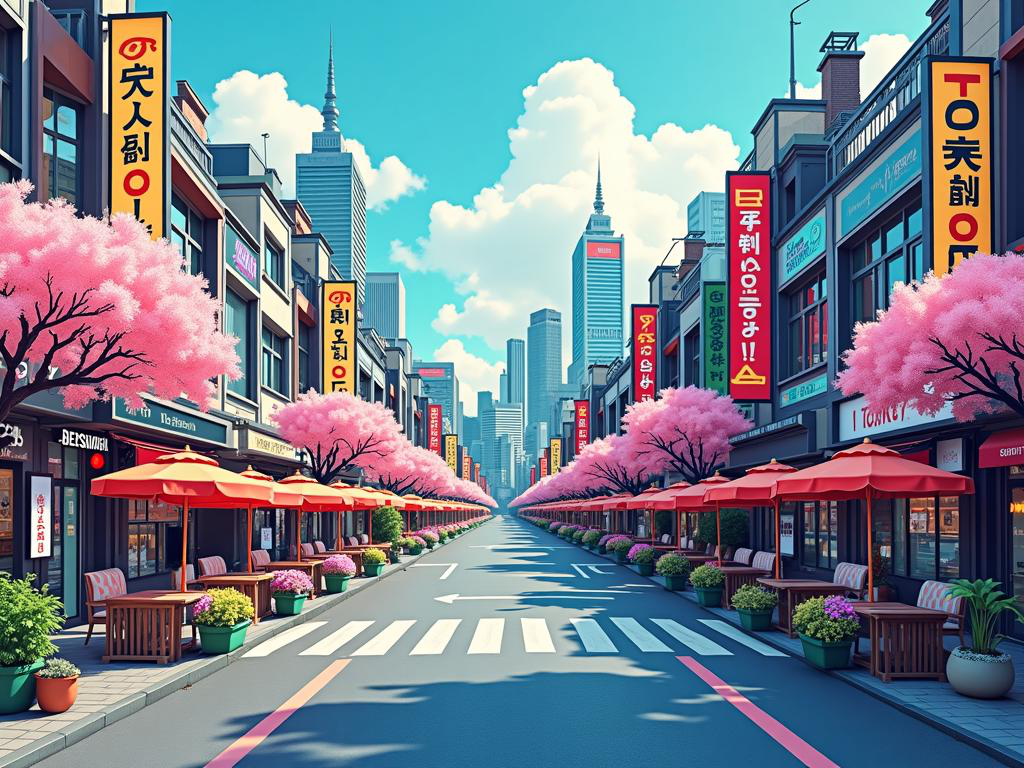

In [7]:
image = image_model("Tokyo")
image

# Model 2: Audio (TTS)

In [6]:
def talker(message):
    response = openai.audio.speech.create(
        model = MODEL_AUD,
        voice = "shimmer",
        input = message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    
    filename = f"temp_{uuid.uuid4().hex}.wav"
    audio.export(filename, format="wav")

    try:
        subprocess.run(["ffplay", "-nodisp", "-autoexit", filename], check=True)
    finally:
        os.remove(filename)

In [108]:
talker("Well, hi there. This is your Airline chatbot")

# Creating Tools

I am planning to create custom tools that simulate various aspects of airline booking, including retrieving the price of return tickets, checking available travel dates, and generating booking confirmation messages.

In [12]:

# For price information
ticket_prices = {"paris":"$900","london":"$1000","california":"$1200","tokyo":"$800","shangai":"$1200","india":"$900"}

def get_ticket_price(destination_city):
    print(f"Tool looking price for {destination_city}....")
    city = destination_city.lower()
    return ticket_prices.get(city,"Unknown")

# For Next available dates
flight_date = {"paris":"25-07-2025","london":"26-07-2025","california":"27-07-2025","tokyo":"26-07-2025","shangai":"28-07-2025","india":"30-07-2025"}

def get_dates(destination_city):
    print(f"Tool looking date for {destination_city}....")
    city = destination_city.lower()
    return flight_date.get(city,"Unknown")

# Flight booking simulation
import random

def book_flight(name, from_city, destination_city, flight_date, slot_time):
    print(f"Tool simulating flight booking for {name} to {destination_city}....")

    prefix_list = ["AI","BA","UA","IN"]
    airline_prefix = random.choice(prefix_list)
    airline_randon_number = random.randint(100, 999)
    flight_time = f"{airline_prefix}:{airline_randon_number}"

    booking_status = "confirmed"

    response_message = (
        f"**Booking Confirmation:**\n"
        f"Name: {name}\n"
        f"From city: {from_city}\n"
        f"Destination city: {destination_city}\n"
        f"Flight_date: {flight_date}\n"
        f"Slot_time: {slot_time}\n"
        f"Booking_status: {booking_status}\n"
        f"You will receive your detailed booking information and e-ticket to your mobile number shortly. Thank you for choosing our airline!")
    return response_message
    

In [14]:
# Shcema

tools = [
    {
        "type":"function",
        "function":{
            "name": "get_ticket_price",
            "description": "Get the price of the return ticket to the destination city, call this whenever customer ask the price for example, How much is the price for the city?",
            "parameters":{
                "type":"object",
                "properties":{
                    "destination_city": {"type":"string",
                                         "description":"The exact name of the destination city the customer wants to travel. Such as 'London','Paris' or 'tokyo'. This must be precise city name mentioned by the user",
                                        }
                },
                "required": ["destination_city"],
                "additionalProperties": False
            }
        }
    },
    {
        "type":"function",
        "function":{
            "name":"get_dates",
            "description": "Get the next available date for the flight, call this whenever customer want to know the next available date for the flight for example, What is the next available flight to the city",
            "parameters":{
                "type":"object",
                "properties":{
                    "destination_city":{"type":"string",
                                        "description":"The exact name of the destination city customer wants to travel, such as 'London','Paris' or 'tokyo' for example, can i know the next available date for the destination",
                                       }
                },
                "required":["destination_city"],
                "additionalProperties":False
            }
        }
    },
    {
        "type":"function",
        "function":{
            "name":"book_flight",
            "description": "Get the details for flight booking , call this whenever customer want to book a ticket for a flight example, can you book the ticket for this destination",
            "parameters":{
                "type":"object",
                "properties":{
                    "name":{
                        "type":"string",
                        "description":"The full name of the passenger(s) booking for the flight"},
                    "from_city":{
                        "type":"string",
                        "description":"The origin city of the flight"},
                    "destination_city":{
                        "type":"string",
                        "description":"The destination city of the customer"},
                    "flight_date":{
                        "type":"string",
                        "description":"The desired date for the flight for example ('25-07-2025','tommorow','Next week','tonight')"},
                    "slot_time":{
                        "type":"string",
                        "description":"The user's preferred time slot for the flight for example ('4:00 AM', '10:00 PM', '6pm','5am')"
                    }
                },
                "required":["name","from_city","destination_city","flight_date","slot_time"],
                "additionalProperties": False
            }
        }
    }]
            
                        


In [16]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments)
    tool_call_id = tool_call.id

    result_content = {}
    city = None
    destination_city = None

    if function_name == "get_ticket_price":
        city = arguments.get("destination_city")
        result_content = {"destination_city": city, "price": get_ticket_price(city)}

    elif function_name == "get_dates":
        city = arguments.get("destination_city")
        result_content = {"destination_city": city, "next_available_date": get_dates(city)}

    elif function_name == "book_flight":
        name = arguments.get("name")
        from_city = arguments.get("from_city")
        destination_city = arguments.get("destination_city")
        flight_date = arguments.get("flight_date")
        slot_time = arguments.get("slot_time")

        if all([name, from_city, destination_city, flight_date, slot_time]):
            booking_response = book_flight(name, from_city, destination_city, flight_date, slot_time)
            result_content = {"destination_city": destination_city, "booking_confirmation": booking_response}
        else:
            result_content = {"error": "Missing required information for flight booking."}
    else:
        result_content = {"error": f"Unknown tool: {function_name}"}

    response = {"role": "tool", "content": json.dumps(result_content), "tool_call_id": tool_call_id}
    return response, city, destination_city

In [26]:
system_prompt = "You are a helful assistant for an Airline called Celestial airlines."
system_prompt += "Give short, courteous answers, no more than 1 sentence."
system_prompt += "Always be accurate, If you don't know the exact answer, say 'i don't know' or 'please refer the website'." 
system_prompt += "To assist users with flight related inquires and facilitate a dummy flight booking, you have access to the follwing tools:\
1. `get_ticket_price(destination_city)` - To find the price of a return ticket price (using internall data)\
2. `get_dates(destination_city)` - To find the next available flight date to a given city (using internal data)\
3. `book_flight(name,from_city,destination_city,flight_date,slot_time)` - To book the flight for any given destination"
system_prompt +=" if user mention a destination city or ask about travel **always provide the next available flight data and price of the ticket"
system_prompt +=" if the accurate information is not availabel on the tools, say i don't know, please refer the website"
system_prompt += "\n\n Examples:\n"
system_prompt += "\nuser: Can you book a flight for the destination? \nFlightAI: collect the informations like name, origin, destination,date,time slot for example, can you give me some information about the travel?\n"
system_prompt += "\nuser: what is the baggage allowance for internation flights? \nFlightAI: please refer to the website\n"
system_prompt += "\nuser: How do I select my seat for flight AI007? \nFlightAI: Please refer to the website for seat selection options\n"

# Model 3: Chatbot Integration

Lets create a fully integrated chatbot that combines our Large Language Model (LLM) for text generation, image generation for visual context, and text-to-speech (TTS) for audio responses. This will be orchestrated through the chat completion model to deliver a seamless, multi-modal user experience.

In [28]:
def chat(message, history):
    image = None
    conversation = [{"role": "system", "content": system_prompt}]
    for item in history:
        conversation.append({"role": item["role"], "content": item["content"]})
    conversation.append({"role": "user", "content": message})

    completion_model = groq_models.chat.completions.create(model=MODEL_TEXT, messages=conversation, tools=tools)

    final_reply = completion_model.choices[0].message
    finish_reason = completion_model.choices[0].finish_reason

    if finish_reason == "tool_calls":
        tool_message = final_reply
        response, city, destination_city = handle_tool_call(tool_message)
        conversation.append(response)

        if city:
            image = image_model(city)  # Image generator
        elif destination_city:
            image = image_model(destination_city)

        completion_model = groq_models.chat.completions.create(model=MODEL_TEXT, messages=conversation)

    final_reply_content = completion_model.choices[0].message.content or ""

    # TTS function now
    talker(final_reply_content)

    return final_reply_content, image


# User Interface

I have implemented the user interface using Gradio, providing an accessible and interactive front-end for our multimodal airline agent. The UI integrates text chat, image display, and audio output to deliver a cohesive user experience.

In [30]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)

    with gr.Row():
        msg = gr.Textbox(label="Chat with our AI Assistants")

    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        if history is None:
            history = []
        history.append({"role": "user", "content": user_message})
        return "", history

    def bot(history):
        if not history or history[-1]["role"] != "user":
            return history, None
        user_message = history[-1]["content"]
        bot_message, image = chat(user_message, history[:-1])
        history.append({"role": "assistant", "content": bot_message})
        return history, image

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, [chatbot, image_output]
    )
    clear.click(lambda: [], None, chatbot, queue=False)

ui.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
